In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

## **CHAPTER 7**
# Ensemble Learning and Random Forests

If you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of predictors
is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.<br>
An ensemble of Decision Trees is called a Random Forest,
and despite its simplicity, this is one of the most powerful Machine Learning algorithms
available today.


### 📌REMEMBER
>Ensemble methods work best when the predictors are as independent
from one another as possible. One way to get diverse classifiers
is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving
the ensemble’s accuracy.

# 1) Voting Classifiers

Training **Random Forest, Logistic Regression and SVC** on Moon's Dataset (Chapter 5)
>A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a hard voting classifier

In [3]:
# Generaging Moons DataSet

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8)


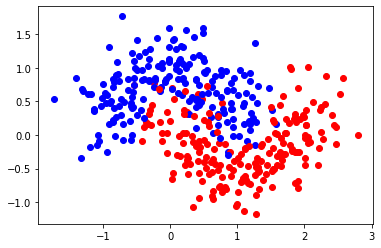

((400, 2), (500, 2))

In [4]:
predicted = y_train
for i in range(len(predicted)):
    if predicted[i]:
        plt.scatter(X_train[i, 0], X_train[i, 1], c="r")
    else:
        plt.scatter(X_train[i, 0], X_train[i, 1], c="b")

plt.show()


X_train.shape,X.shape

In [5]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf  = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.83
RandomForestClassifier 0.88
SVC 0.9
VotingClassifier 0.9


There you have it! The voting classifier slightly outperforms all the individual classifiers.<br>
PS: It is not always going to be so try to apply soft voting

#### 🍦 Soft Voting
>If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities.


# 2) Bagging and Pasting
**Bootstrapping**<br>
In statistics, bootstrapping refers to a resample method that consists of repeatedly drawn, with replacement, samples from data to form other smaller datasets, called bootstrapping samples. It’s as if the bootstrapping method is making a bunch of simulations to our original dataset so in some cases we can generalize the mean and the standard deviation.

For example, let’s say we have a set of observations: [2, 4, 32, 8, 16]. If we want each bootstrap sample containing n observations, the following are valid samples:

n=3: [32, 4, 4], [8, 16, 2], [2, 2, 2]…
n=4: [2, 32, 4, 16], [2, 4, 2, 8], [8, 32, 4, 2]…
Since we drawn data with replacement, the observations can appear more than one time in a single sample.<br>.<br>
**Bagging & Pasting**<br>
Bagging means bootstrap+aggregating and it is a ensemble method in which we first bootstrap our data and for each bootstrap sample we train one model. After that, we aggregate them with equal weights. When it’s not used replacement, the method is called pasting.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.86


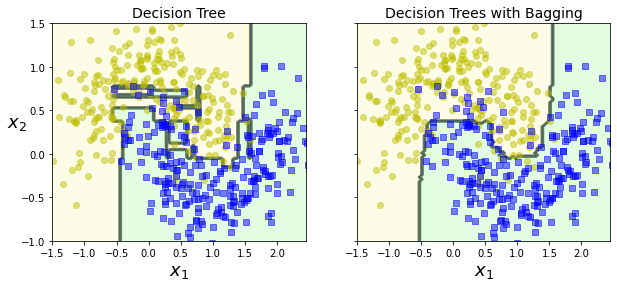

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score
pas_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500, 
    max_samples=100, bootstrap=False, n_jobs=-1)
    
pas_clf.fit(X_train, y_train)
pas_pred = pas_clf.predict(X_test)
accuracy_score(y_test,pas_pred)

0.9